# EVEN MORE CAR TALK: BAYESIAN PRICING
**_The search for normality and significance_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### Homework 6: Applying Bayesian modeling to auto price data
#### Leo Salemann, 2/14/18


# Load Data, Setup some Functions

In [1]:
read.auto = function(file = '../../../DataScience410/Lecture1/Automobile price data _Raw_.csv'){
  ## Read the csv file
  autos <- read.csv(file, header = TRUE, 
                      stringsAsFactors = FALSE)

  ## Coerce some character columns to numeric
  numcols <- c('price', 'bore', 'stroke', 'horsepower', 'peak.rpm')
  autos[, numcols] <- lapply(autos[, numcols], as.numeric)

  ## Remove cases or rows with missing values. In this case we keep the 
  ## rows which do not have nas. 
  autos[complete.cases(autos), ]
}
autos = read.auto()

head(autos, 3)

Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”

symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,engine.size,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,⋯,152,mpfi,2.68,3.47,9,154,5000,19,26,16500


In [2]:
autos$logPrice = log(autos$price)
head(autos, 3)

symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price,logPrice
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,13495,9.510075
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,16500,9.711116
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,⋯,mpfi,2.68,3.47,9,154,5000,19,26,16500,9.711116


# Bayesian Estimate, Stratified by Aspiration
Compare the difference of the Bayesian estimate of the mean of log of auto price stratified by 1) aspiration and 2) fuel type. Use both numerical and graphical methods for your comparison. 

- Are these means different within a 95% credible interval? 
- How do your conclusions compare to the results you obtained using the to the bootstrap resampled distribution of the mean and the t-test on the log price?   
- Use a Normal(mean(sample), sigma(sample)) as your prior distribution for both exercises. 
- Use sigma(sample), the empirical value of the standard deviation, as a fixed parameter in your likelihood for both exercises. 

In [4]:
autos.std = autos[autos$aspiration == 'std',]
autos.turbo = autos[autos$aspiration == 'turbo',]

head(autos.std, 3)
head(autos.turbo, 3)

symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price,logPrice
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,13495,9.510075
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,16500,9.711116
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,⋯,mpfi,2.68,3.47,9,154,5000,19,26,16500,9.711116


,symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price,logPrice
9,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,⋯,mpfi,3.13,3.40,8.3,140,5500,17,20,23875,10.080587
24,1,118,dodge,gas,turbo,two,hatchback,fwd,front,93.7,⋯,mpfi,3.03,3.39,7.6,102,5500,24,30,7957,8.981807
28,1,148,dodge,gas,turbo,?,sedan,fwd,front,93.7,⋯,mpfi,3.03,3.39,7.6,102,5500,24,30,8558,9.054622


## Set up the Prior Distribution
### THIS WAS DONE AT THE END OF INTRO TO BAYES
### SEE THE GALTON FAMILY STUFF

Normal(mean(sample), sigma(sample))

Use a Normal likelihood function with fixed standard deviation. Use the sample standard deviation, which can be for all cars or it will usually be better to compute this for the subset. 


### Here's what worked in IntroducitonToBayes
It used a uniform distribution. From the Text:

_Let's test a prior distribution for our one model parameter $p$, $P(p)$. We don't know a lot about these drivers at this point, so we will start with a Uniform distribution._

_The code in the cell below computes and plots the uniform prior distribution. Execute this code and examine the results._

Seems we just need a different equattion for pp or something

Loading required package: repr


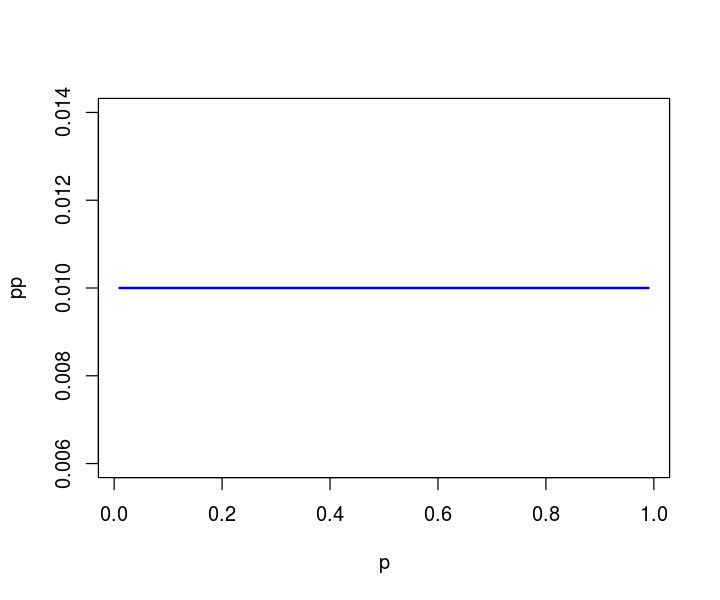

In [2]:
require(repr)
options(repr.plot.width=6, repr.plot.height=5) ## Set the plot area

N = 100
p = seq(0.01, 0.99, length = N) 
pp = rep(1/N, length = N)
plot(p, pp, typ = 'l', lwd = 2, col = 'blue')

In [ ]:
require(graphics)

dnorm(0) == 1/sqrt(2*pi)
dnorm(1) == exp(-1/2)/sqrt(2*pi)
dnorm(1) == 1/sqrt(2*pi*exp(1))

## Using "log = TRUE" for an extended range :
par(mfrow = c(2,1))
plot(function(x) dnorm(x, log = TRUE), -60, 50,
     main = "log { Normal density }")
curve(log(dnorm(x)), add = TRUE, col = "red", lwd = 2)
mtext("dnorm(x, log=TRUE)", adj = 0)
mtext("log(dnorm(x))", col = "red", adj = 1)



In [19]:
mean.std = mean(autos.std$logPrice)
sd.std = sd(autos.std$logPrice)

mean.turbo = mean(autos.std$logPrice)
sd.turbo= sd(autos.turbo$logPrice)

# prior.std = dnorm(quantile(autos.std$logPrice) mean.std, sd.std)
prior.std = rnorm(nrow(autos.std), mean.std, sd.std)
prior.tubo = dnorm(quantile(autos.turbo$logPrice), mean.turbo, sd.turbo)

# prior.std

In [12]:
sd.std
mean.std

[1] 0.5140133

[1] 9.287064

In [20]:
prior.std

[1]  9.933843  9.618475  9.525230  9.683011  9.170725  9.106363  8.953305
  [8]  8.638075  8.414714  8.344351  8.864092  8.455382  9.443929 10.054573
 [15]  9.301839  8.997720  9.519588  9.596237  9.855123  8.280723  9.262051
 [22]  9.796708  8.950931  9.049052  8.757254  8.910441  9.581261  8.997704
 [29]  8.640165  8.962531  9.111946  9.517598  9.785273  8.855109  9.820953
 [36]  9.271150  9.108014  9.246014  8.133003  9.698176  8.014870  9.949411
 [43]  9.542905 10.024828  8.947577  8.764159  9.177858  8.960082  9.455996
 [50]  8.871279  9.666747  9.201803  9.313475  9.389270  9.371095  9.221157
 [57] 10.635856 10.307449 10.142785  8.763878  8.889975  9.000691 10.118880
 [64]  9.230576  9.162653  9.725786  8.802855  8.620476  9.008493  9.330118
 [71]  9.001329  8.728877  8.691985  9.177199 10.189224  9.585408 10.495749
 [78]  9.604915  9.175965  9.422964  9.440628  8.636598  8.618502  9.417374
 [85]  9.414207  9.120041  9.646755  9.918826 10.045777 10.206541  8.778873
 [92]  9.429211  8.813318  9.232653  9.179578  9.235678  8.769671  9.119590
 [99]  9.462423  8.771968  9.070515  9.616901  9.803733  9.121215  8.997478
[106]  9.449042  8.193517  9.564343  8.854226  8.856057  9.152768 10.035075
[113]  8.970821  9.637778  9.310786  8.924016  9.159239  8.803923  9.958220
[120]  9.181787  8.618261  8.914998  9.585089  9.666227 10.163664 10.243467
[127]  8.672350  9.277466  9.641054  9.762393 10.029823 10.137900  9.529089
[134]  8.329920  9.513405  8.828794  9.991152  8.925127  8.286754  9.391785
[141]  8.827938  9.482688  9.074306  9.249781  9.265741  9.621835  9.495126
[148]  8.990830  9.619158 10.364125  9.944646  8.920863 10.982844  8.811276
[155]  8.929856  9.027513  8.970550  8.963010  9.151027

In [15]:
# from https://www.r-bloggers.com/normal-distribution-functions/

xseq<-seq(mean.std - 3*sd.std,
          mean.std + 3*sd.std,
          .01)
densities<-prior.std

plot(xseq, densities, col="darkgreen",xlab="", ylab="Density", type="l",lwd=2, cex=2, 
     main="PDF of Standard Normal", cex.axis=.8)

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


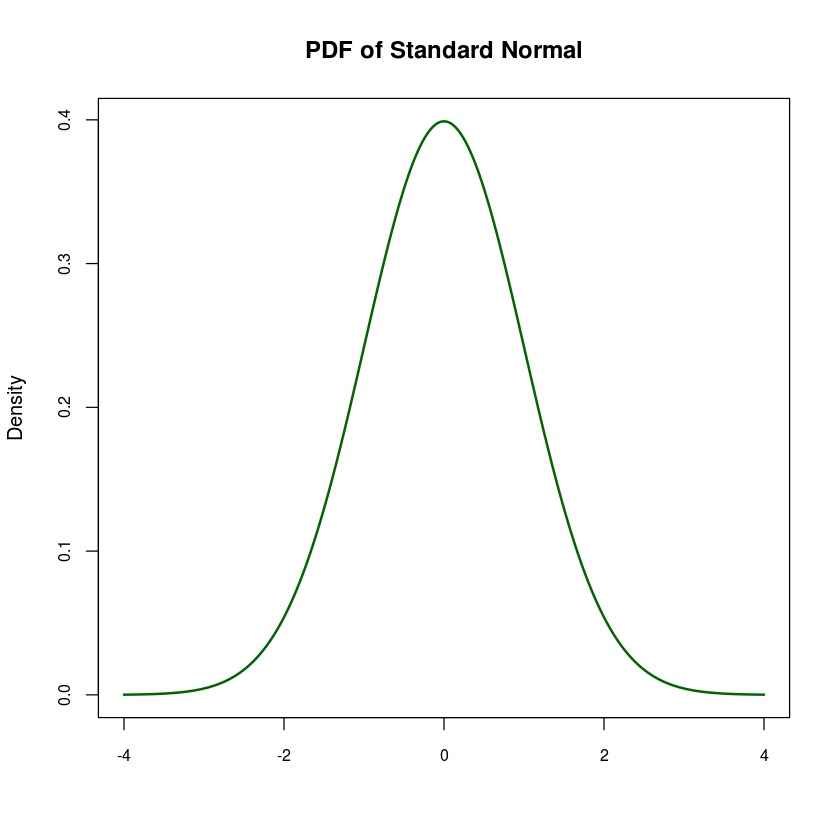

In [10]:
# from https://www.r-bloggers.com/normal-distribution-functions/

xseq<-seq(-4,4,.01)
densities<-dnorm(xseq, 0,1)

plot(xseq, densities, col="darkgreen",xlab="", ylab="Density", type="l",lwd=2, cex=2, 
     main="PDF of Standard Normal", cex.axis=.8)

In [ ]:
plot(function(x) dnorm(x, log = TRUE), -1. 1)

In [ ]:
require(repr)
options(repr.plot.width=6, repr.plot.height=5) ## Set the plot area

N = nrow(prior.std)
p = seq(0.01, 0.99, length = N) 
pp = prior.std
plot(p, pp, typ = 'l', lwd = 2, col = 'blue')

In [ ]:
require(repr)
options(repr.plot.width=6, repr.plot.height=5) ## Set the plot area

N = 100
p = seq(0.01, 0.99, length = N) 
pp = rep(1/N, length = N)
plot(p, pp, typ = 'l', lwd = 2, col = 'blue')

In [ ]:
## 

# Bayesian Estimate, Stratified by Fuel Type
Compare the difference of the Bayesian estimate of the mean of log of auto price stratified by 1) aspiration and 2) fuel type. Use both numerical and graphical methods for your comparison. 

- Are these means different within a 95% credible interval? 
- How do your conclusions compare to the results you obtained using the to the bootstrap resampled distribution of the mean and the t-test on the log price?
- Use a Normal(mean(sample), sigma(sample)) as your prior distribution for both exercises. 
- Use sigma(sample), the empirical value of the standard deviation, as a fixed parameter in your likelihood for both exercises.  

In [ ]:
autos.gas = auto.price[auto.price$fuel.type == 'gas',]
autos.diesel = auto.price[auto.price$fuel.type == 'diesel',]

# Bayesian Estimate, Stratified by Body Style
- Compare the differences of the Bayesian estimate of the distribution of the log price of the autos grouped by body style. You will need to do this pair wise; e.g. between each possible pairing of body styles. Use both numerical and graphical methods for your comparison. 
- Which pairs of means are different within a 95% credible interval? 
- How do your conclusions compare to the results you obtained from the bootstrap method, ANOVA and Tukey’s HSD analysis you previously performed? 
- Notice that the posterior is closer to the likelihood for groups with more data values. 

- Use a Normal(mean(sample), sigma(sample)) as your prior distribution for both exercises. Use sigma(sample), the empirical value of the standard deviation, as a fixed parameter in your likelihood for both exercises.  

# vvvvvvvvvvvvvvvvv JUNK vvvvvvvvvvvvvvvvvvvvvvvv

In [ ]:
t = 1/3
print(t)
print(format(round(t, 2), nsmall=2))
paste(format(round(t, 2), nsmall=2))

In [ ]:
plot.hist <- function(a, maxs, mins, cols = 'difference of means', 
                      nbins = 80, p = 0.05, digits = 3, ...) {
    
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  
  m     = mean(a)
  ci_lo = quantile(a, probs = p/2)
  ci_hi = quantile(a, probs = (1 - p/2)) 
    
  p_m     = format(round(m,     digits), nsmall=digits)
  p_ci_lo = format(round(ci_lo, digits), nsmall=digits)
  p_ci_hi = format(round(ci_hi, digits), nsmall=digits)

  hist(a, breaks = breaks, 
       main = paste('Histogram of', cols, '\n',
                    'mean=', p_m, '; confidence interval =[', p_ci_lo, ', ', p_ci_hi, ']'), 
       xlab = cols)
  abline(v = m, lwd = 4, col = 'red')
  abline(v = 0, lwd = 4, col = 'blue')
  abline(v = ci_lo, lty = 3, col = 'red', lwd = 3)  
  abline(v = ci_hi, lty = 3, col = 'red', lwd = 3)
}

plot.t <- function(a, b, cols = c('pop_A', 'pop_B'), nbins = 80, 
                   p_cutoff = 0.05, format_digits = 2){
  maxs = max(c(max(a), max(b)))
  mins = min(c(min(a), min(b)))
  par(mfrow = c(2, 1))
  plot.hist(a, maxs, mins, cols = cols[1], nbins, p_cutoff, format_digits)
  plot.hist(b, maxs, mins, cols = cols[2], nbins, p_cutoff, format_digits)
  par(mfrow = c(1, 1))
}


In [ ]:
## Bootstrap the difference in means of sons and daughters
plot.diff <- function(a, cols = 'difference of means', nbins = 80, 
                      pval = 0.05, print_digits = 2){
  maxs = max(a)
  mins = min(a)
  plot.hist(a, maxs, mins, cols = cols[1], p_cutoff = pval, 
            format_digits = print_digits)
}

In [ ]:
library(resample)
library(simpleboot)

# Bootstrapped Means, Aspiration and Fuel
Compare the difference of the bootstrap resampled mean of the log price of autos grouped by 1) aspiration and 2) fuel type. Use both numerical and graphical methods for your comparison. Are these means different within a 95% confidence interval? How do your conclusions compare to the results you obtained using the t-test last week?

## Graphical Approach

## Dfference of means, bootstrapped gas vs. diesel
### [TODO] get some better labelling on the graph

In [ ]:
require(repr)
options(repr.plot.width=6, repr.plot.height=2)

## Bootstrap the mean of the gas vs. diesel, plot individual histograms
mean.boot.gas = one.boot(log(autos.gas$price), mean, R = 100000)
mean.boot.diesel = one.boot(log(autos.diesel$price), mean, R = 100000)
options(repr.plot.width=6, repr.plot.height=8)
plot.t(mean.boot.gas$t, mean.boot.diesel$t, nbins = 80, cols = c('gas', 'diesel'), format_digits = 3)


# Plot the difference
options(repr.plot.width=6, repr.plot.height=3)
two.boot.mean = two.boot(log(autos.gas$price), log(autos.diesel$price), mean, R = 100000)
plot.diff(two.boot.mean$t)

### Conclusions, Graphical Analysis
- Histograms exhibit some overlap, but the mean of one does not fall within the 95% conficence interval of the mean of the other.
- Mean log(price) is 0.2 less for gas cars vs. diesel.  Both sides of the 95% confidence level are to the left of zero.
- Fuel type has a significant impact on price

## Numerical Approach
Just by comparing the numerical values of the confidence intervals of the bootstrap distribution of the mean. The other method is to plot the histogram of the bootstrap distribution showing the mean and the confidence intervals.

In [ ]:
mean.boot.gas$t0
mean(mean.boot.gas$t)

In [ ]:
mean(mean.boot.gas$t)
quantile(mean.boot.gas$t, 0.05)
quantile(mean.boot.gas$t, 0.95)

## Dfference of means, bootstrapped standard vs. turbo
### [TODO] get some better labelling on the graph

In [ ]:
autos.std = auto.price[auto.price$aspiration == 'std',]
autos.turbo = auto.price[auto.price$aspiration == 'turbo',]

In [ ]:
require(repr)
options(repr.plot.width=6, repr.plot.height=2)

## Bootstrap the mean of the gas vs. diesel, plot individual histograms
mean.boot.std = one.boot(log(autos.std$price), mean, R = 100000)
mean.boot.turbo = one.boot(log(autos.turbo$price), mean, R = 100000)
options(repr.plot.width=6, repr.plot.height=8)
plot.t(mean.boot.std$t, mean.boot.turbo$t, nbins = 80, cols = c('std', 'turbo'))

# Plot the difference
options(repr.plot.width=6, repr.plot.height=3)
two.boot.mean = two.boot(log(autos.std$price), log(autos.turbo$price), mean, R = 100000)
plot.diff(two.boot.mean$t)

### Conclusions, Graphical Analysis
- Individual histograms are widely separated.
- Difference histogram, shows a mean and 95% confidence interval far from zero.
- Mean log(price) of standard fuel cars is about 0.35 less than turbo
- Fuel aspiration has a significant impact on price

## Numerical Approach
Just by comparing the numerical values of the confidence intervals of the bootstrap distribution of the mean. The other method is to plot the histogram of the bootstrap distribution showing the mean and the confidence intervals.

## Conclusion
Are these means different within a 95% confidence interval? How do your conclusions compare to the results you obtained using the t-test last week?

# Bootstrapped Means, Body Style
Compare the differences of the bootstrap resampled mean of the log price of the autos grouped by body style. You will need to do this pair wise; e.g. between each possible pairing of body styles. Use both numerical and graphical methods for your comparison. Which pairs of means are different within a 95% confidence interval? How do your conclusions compare to the results you obtained from the ANOVA and Tukey’s HSD analysis you performed last week?

## Graphical Approach

### Gather up the groupings

In [ ]:
autos.sedan     = auto.price[auto.price$body.style == 'sedan',]
autos.hatchback = auto.price[auto.price$body.style == 'hatchback',]
autos.wagon     = auto.price[auto.price$body.style == 'wagon',]

In [ ]:
## Bootstrap the mean of the gas vs. diesel, plot individual histograms
mean.boot.sedan     = one.boot(log(autos.sedan$price), mean, R = 100000)
mean.boot.hatchback = one.boot(log(autos.hatchback$price), mean, R = 100000)
mean.boot.wagon     = one.boot(log(autos.wagon$price), mean, R = 100000)

#### Sedan vs. Hatchback

In [ ]:
options(repr.plot.width=6, repr.plot.height=8)
plot.t(mean.boot.sedan$t, mean.boot.hatchback$t, nbins = 80, cols = c('sedan', 'hatchback'))

# Plot the difference
options(repr.plot.width=6, repr.plot.height=3)
two.boot.mean = two.boot(log(autos.sedan$price), log(autos.hatchback$price), mean, R = 100000)
plot.diff(two.boot.mean$t)

#### Wagon vs. Hatchback

In [ ]:
options(repr.plot.width=6, repr.plot.height=8)
plot.t(mean.boot.wagon$t, mean.boot.hatchback$t, nbins = 80, cols = c('wagon', 'hatchback'))

# Plot the difference
options(repr.plot.width=6, repr.plot.height=3)
two.boot.mean = two.boot(log(autos.wagon$price), log(autos.hatchback$price), mean, R = 100000)
plot.diff(two.boot.mean$t)

#### Wagon vs. Sedan

In [ ]:
options(repr.plot.width=6, repr.plot.height=8)
plot.t(mean.boot.wagon$t, mean.boot.sedan$t, nbins = 80, cols = c('wagon', 'sedan'))

# Plot the difference
options(repr.plot.width=6, repr.plot.height=3)
two.boot.mean = two.boot(log(autos.wagon$price), log(autos.sedan$price), mean, R = 100000)
plot.diff(two.boot.mean$t)

## Compare to ANOVA/TukeyHSD

### Brief digression back to ANOVA

In [ ]:
autos.body.style = auto.price[auto.price$body.style %in% c("hatchback","sedan", "wagon"),]
autos.body.style.aov = aov(log(price) ~ body.style, data = autos.body.style)
autos.body.style.hsd = TukeyHSD(autos.body.style.aov)

In [ ]:
options(repr.plot.width=8, repr.plot.height=3)
par (las=2)
par(mar=c(5,10,3,1))
plot(autos.body.style.hsd)

### Conclusion, Bootstrap vs. ANOVA, Graphical Approach
 - TukeyHSD says ...
   - Sedan/Hatchback well-differentiated
   - Wagon/Hatchback almost/not-quite differentiated
   - Wagon/Sedan not at all differentiated
 - Bootsrap says ... 
   - Sedan/Hatchback well-differentiated
   - Wagon/Hatchback well-differentiated
   - Wagon/Sedan not at all differentiated
   
Bootstratpping found differentiaont where TukeyHSD didn't. Seems that you can use TukeyHSD to find the "near-misses" (e.g., Wagon vs. Hatchback) then verify them with Bootstratp

## Numerical Approach
Just by comparing the numerical values of the confidence intervals of the bootstrap distribution of the mean. The other method is to plot the histogram of the bootstrap distribution showing the mean and the confidence intervals.

## Conclusion
Which pairs of means are different within a 95% confidence interval? How do your conclusions compare to the results you obtained from the ANOVA and Tukey’s HSD analysis you performed last week?

# vvvvvvvvvvvvvv JUNK vvvvvvvvvv

## Normalize Pricing values
Get everything ranging from zero to one.
normit function from  [stack overlow](https://stackoverflow.com/questions/5665599/range-standardization-0-to-1-in-r)

In [ ]:
prices = auto.price$price
prices.log = log(auto.price$price)

normit = function(x){(x-min(x))/(max(x)-min(x))}

prices.norm = normit(prices)
prices.log.norm = normit(prices.log)

head(prices.norm)
head(prices.log.norm)

# Compare and test Normality: A Graphical Approach

## Start with paired Q-Q plots  

In [ ]:
options(repr.plot.width=5, repr.plot.height=3)

# Visual test of normality
par(mfrow = c(1, 2))
qqnorm(prices.norm, main = 'Q-Q plot of Price')
qqnorm(prices.log.norm, main = 'Q-Q plot of log(Price)')
par(mfrow = c(1, 1))

Log(Price) appears to be closer to normal (e.g. a move of a straight line) than regular prce.

## A closer look with individual plots

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

# Visual test of normality
qqnorm(prices.norm, main = 'Q-Q plot of Price')
abline(a = 0.0, b = 1.0, lty = 2, col = 'blue')

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

# Visual test of normality
qqnorm(prices.log.norm, main = 'Q-Q plot of log(Price)')
abline(a = 0.0, b = 1.0, lty = 2, col = 'blue')

There's a tiny patch between the 0.4 and 0.6 quantiles where log(Price) matches a normal distribution; regular Price doesn't come close.

# Compare and test Normality: Formal tests though K-S Statistics

In [ ]:
normal.distro = rnorm(948) ## Our standard Normal for comparison.
ks.test(prices.norm, normal.distro, alternative = "two.sided") 
ks.test(prices.log.norm, normal.distro, alternative = "two.sided") 


Analyticlally, the p-values are the same; can't tell the difference.


## Conclusion, Normality Tests
Both are terrible, but log of price is just-slightly more similar to a normal distributon.

# Testing Significance of log(Price) based on fuel, aspiration, drive train

## Significance by Fuel Type: Are Diesel Cars More Expensive than Gas?

Start with a plot function that we'll be using over and over again.

In [ ]:
plot.t <- function(a, b, cols = c('pop_A', 'pop_B'), nbins = 20){
  maxs = max(c(max(a), max(b)))
  mins = min(c(min(a), min(b)))
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  par(mfrow = c(2, 1))
  hist(a, breaks = breaks, main = paste('Histogram of', cols[1]), xlab = cols[1])
  abline(v = mean(a), lwd = 4, col = 'red')
  hist(b, breaks = breaks, main = paste('Histogram of', cols[2]), xlab = cols[2])
  abline(v = mean(b), lwd = 4, col = 'red')
  par(mfrow = c(1, 1))
}

In [ ]:
table(auto.price$fuel.type)

In [ ]:
autos.gas = auto.price[auto.price$fuel.type == 'gas',]
autos.diesel = auto.price[auto.price$fuel.type == 'diesel',]
autos.gas.log.prices = log(autos.gas$price)
autos.diesel.log.prices = log(autos.diesel$price)

In [ ]:
plot.t(autos.gas.log.prices, autos.diesel.log.prices, 
       cols = c('log(Gas Auto Price)', 'log(Diesel Auto Price)'))

t.test(autos.gas.log.prices, autos.diesel.log.prices, alternative = "two.sided")

* Histograms appear to have significant overlap, with means fairly close together.

* P-value indicates we'd obtain the observed difference (or larger) in 5.6% of samples due to random sample error. 

* The 95% confidence interval straddles zero. 

* All the above suggests diesel autos *are not* reliably more expensive than gas autos.

## Aspiration: Are Turbos more expensive? 

In [ ]:
head(auto.price, 3)

In [ ]:
table(auto.price$aspiration)

In [ ]:
autos.std = auto.price[auto.price$aspiration == 'std',]
autos.turbo = auto.price[auto.price$aspiration == 'turbo',]
autos.std.log.prices = log(autos.std$price)
autos.turbo.log.prices = log(autos.turbo$price)

In [ ]:
plot.t(autos.std.log.prices, autos.turbo.log.prices, 
       cols = c('log(Auto Prices), std Aspiration', 'log(Auto Prices), Turbo'))

t.test(autos.std.log.prices, autos.turbo.log.prices, alternative = "two.sided")

* Histograms appear to have somewhat divergent shapes with a fairly big gap between means.

* P-value is infinitessimal, indicating it would be highly unlikely that any observed price difference is due to random sampling error.

* Both sides of the 95% confidence interval is on the same side of zero

* All the above suggests a turbo charger is usually going to have a signtificant impact on price.

## Drive Train: Is Front-Wheel Drive cheaper than Rear Wheeel?

In [ ]:
head(auto.price, 3)

In [ ]:
table(auto.price$drive.wheels)

In [ ]:
autos.fwd = auto.price[auto.price$drive.wheels == 'fwd',]
autos.rwd = auto.price[auto.price$drive.wheels == 'rwd',]
autos.fwd.log.prices = log(autos.fwd$price)
autos.rwd.log.prices = log(autos.rwd$price)

In [ ]:
plot.t(autos.fwd.log.prices, autos.rwd.log.prices, 
       cols = c('log of Auto Prices, FWD', 'log of Auto Prices, RWD'))

t.test(autos.fwd.log.prices, autos.rwd.log.prices, alternative = "two.sided")

* Histograms appear to have higlly divergent shapes with a major gap between means.

* P-value is infinitessimal, indicating it would be highly unlikely that any observed price difference is due to random sampling error.

* Both sides of the 95% confidence interval is on the same side of zero

* All the above indicates you're practically guaranteed to save money by picking front-wheel drive.

# Pricing and Body Style

## Price by body style, ANOVA

In [ ]:
head(auto.price, 4)

In [ ]:
table (auto.price$body.style)

Drop convertibles and hardtops, since there aren't very many of them.

In [ ]:
autos.body.style = auto.price[auto.price$body.style %in% c("hatchback","sedan", "wagon"),]
table (autos.body.style$body.style)

In [ ]:
autos.body.style.aov = aov(log(price) ~ body.style, data = autos.body.style)
summary(autos.body.style.aov)

P-value indicates at least two body styles have a significant price difference.

In [ ]:
print(autos.body.style.aov)

In [ ]:
options(repr.plot.width=4, repr.plot.height=6)
boxplot(log(autos.body.style$price) ~ autos.body.style$body.style)

* Sedan and Wagon appear very similar
* Greatest difference appears to be between hatchback and wagon

## Price by body style, Tukey HSD

In [ ]:
autos.body.style.hsd = TukeyHSD(autos.body.style.aov)
autos.body.style.hsd

* P-values indicate a signtificant price (okay, log(price) difference betwen sedans & hatchbacks.
* Wagons & Hatchbacks fall just-short of the 5% p-value threshold.
* Wagon vs.  Sedan body style is not a good price indicator.

las parameter setting from [stack overvlow](https://stackoverflow.com/questions/1828742/rotating-axis-labels-in-r)

mar parameter from [r-bloggers](https://www.r-bloggers.com/setting-graph-margins-in-r-using-the-par-function-and-lots-of-cow-milk/)

Tukey HSD validates the "hunch" we got from ANOVA
* There's a singificant difference between sedans and hatchbacks. 
* Wagons vs. Hatchback almost makes the cut, but not quite.
* Wagan vs. Sedan does not have a significant impact on price.